In [22]:
import os
#

In [23]:
# License: BSD
# Based on : Sasank Chilamkurthy
# Modificado 20211210

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

EPOCHS=200

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 'test': transforms.Compose([
        transforms.RandomRotation(degrees=300),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Set clasificado 
data_dir = '/home/pablo/MEGA/pub/ITBA/ECD/tpfinal/work/clasificades'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

## Torch Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


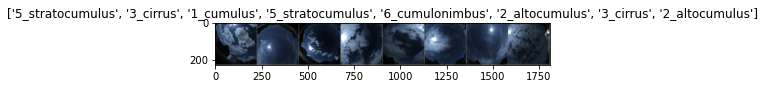

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Savernet
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


## Train

In [26]:
def train_model(model, dataldr, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    since = time.time()

    best_acc = 0.0
    vals_train_loss = []
    vals_test_loss = []
    vals_train_acc = []
    vals_test_acc = []
    epoch_times = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        since_epoch = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataldr[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                vals_train_loss.append(epoch_loss)
                vals_train_acc.append(epoch_acc)
            else:
                vals_test_loss.append(epoch_loss)
                vals_test_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_elapsed = time.time() - since_epoch
        epoch_times.append(epoch_elapsed)
        print('Epoch complete in {:.0f}m {:.0f}s'.format(epoch_elapsed // 60, epoch_elapsed % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, vals_train_loss, vals_test_loss, vals_train_acc, vals_test_acc

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [27]:
modelo = models.resnet18(pretrained=True)
num_ftrs = modelo.fc.in_features
modelo.fc = nn.Linear(num_ftrs, len(class_names))

modelo = modelo.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(modelo.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [28]:
train_losess = []
test_losess = []
train_accuracy = []
test_accuracy = []
model_ft, train_losses, test_losses, train_accuracy, test_accuracy = train_model(modelo, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/199
----------
train Loss: 1.0985 Acc: 0.5980
test Loss: 1.0058 Acc: 0.6308
Epoch complete in 1m 7s

Epoch 1/199
----------
train Loss: 0.8432 Acc: 0.7016
test Loss: 0.9074 Acc: 0.6624
Epoch complete in 1m 8s

Epoch 2/199
----------
train Loss: 0.7174 Acc: 0.7474
test Loss: 0.8932 Acc: 0.6815
Epoch complete in 1m 9s

Epoch 3/199
----------
train Loss: 0.6917 Acc: 0.7496
test Loss: 1.0368 Acc: 0.6556
Epoch complete in 1m 9s

Epoch 4/199
----------
train Loss: 0.6434 Acc: 0.7696
test Loss: 0.7846 Acc: 0.7034
Epoch complete in 1m 9s

Epoch 5/199
----------
train Loss: 0.6124 Acc: 0.7849
test Loss: 0.7997 Acc: 0.7102
Epoch complete in 1m 7s

Epoch 6/199
----------
train Loss: 0.5994 Acc: 0.7865
test Loss: 0.8485 Acc: 0.6854
Epoch complete in 1m 8s

Epoch 7/199
----------
train Loss: 0.4968 Acc: 0.8163
test Loss: 0.7784 Acc: 0.7107
Epoch complete in 1m 9s

Epoch 8/199
----------
train Loss: 0.4765 Acc: 0.8228
test Loss: 0.8072 Acc: 0.7130
Epoch complete in 1m 8s

Epoch 9/199
-------

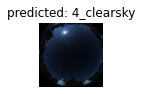

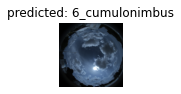

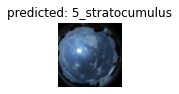

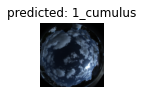

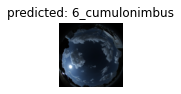

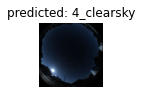

In [29]:
visualize_model(modelo)

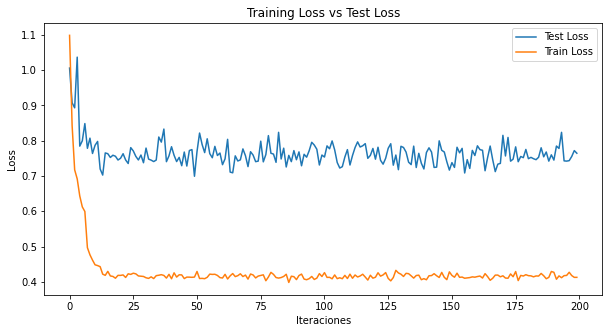

In [30]:
plt.figure(figsize=(10,5))
plt.title("Training Loss vs Test Loss")
plt.plot(test_losses,label="Test Loss")
plt.plot(train_losses,label="Train Loss")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.legend()
plt.show()


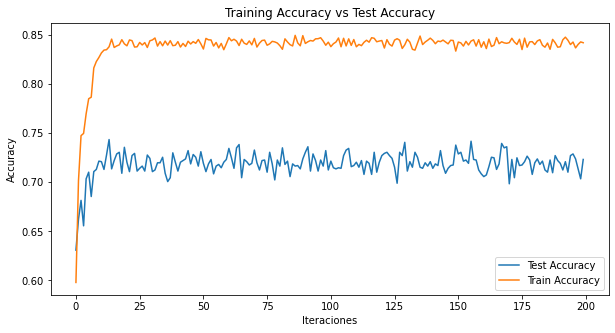

In [31]:
plt.figure(figsize=(10,5))
plt.title("Training Accuracy vs Test Accuracy")
plt.plot(test_accuracy,label="Test Accuracy")
plt.plot(train_accuracy,label="Train Accuracy")
plt.xlabel("Iteraciones")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
#persisto modelo mgcd
#path = '/content/drive/My Drive/savernet/modelos/chkp_modelo_sv.pt'
path = 'chkp_modelo_sv.pt'
torch.save({
            'train_losses': train_losses, 
            'test_losses': test_losses, 
            'train_accuracy': train_accuracy, 
            'test_accuracy': test_accuracy, 
            'model_ft_state_dict': modelo.state_dict()
            }, path)

In [33]:
# Matriz de Confusión
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def get_num_correct(preds, labels):
    if torch.cuda.is_available():
        preds = preds.cuda()
        labels = labels.cuda()
    
    return preds.argmax(dim=1).eq(labels).sum().item()

@torch.no_grad()
def get_all_preds(model, loader):
    
    print(len(loader))
    i=0
    all_preds = torch.cuda.FloatTensor([])
    for batch in loader:
        images, labels = batch
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        #borrar
        i=i+1
        if ((i % 50) == 0):
            print(i)
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    print(type(cm))
    print(type(classes))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Predicciones MGCD
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=10)
    train_preds = get_all_preds(modelo, prediction_loader)

706
50
100
150
200
250
300
350
400
450
500
550
600
650
700


Total Correctas: 6082
Accuracy: 0.8622058406577828
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
Confusion matrix, without normalization
[[ 610   12   17    7   41  191   15]
 [  18  805   69    2   39    1   15]
 [  22   27  826   10   15   15   13]
 [   1    0    4 1087    0    0    0]
 [  69   18   16    2  797   12   12]
 [ 204    0    3    0    7 1164    1]
 [  18   22   25    0   25    4  793]]


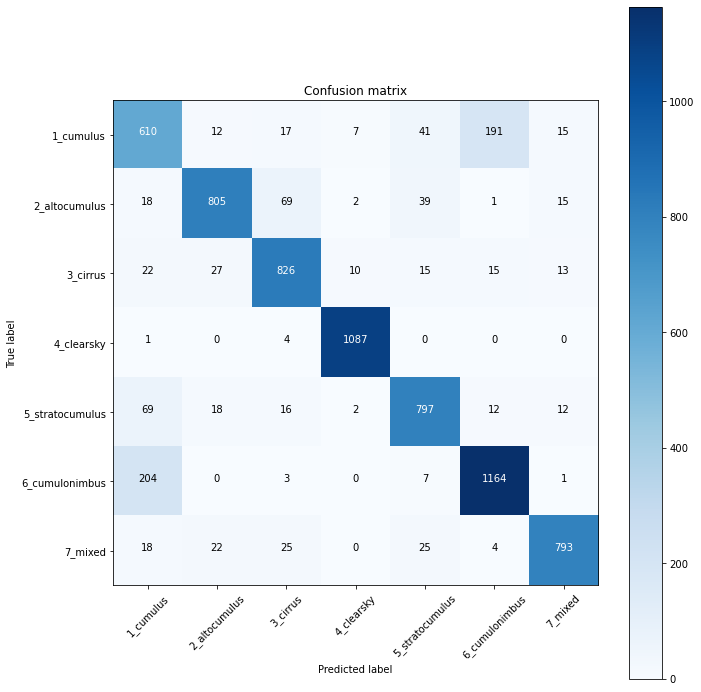

In [ ]:
# CM
preds_correct = get_num_correct(train_preds, torch.as_tensor(image_datasets['train'].targets))
#preds_correct = get_num_correct(train_preds, image_datasets['train'].targets)
print('Total Correctas:', preds_correct)
print('Accuracy:', preds_correct / len(image_datasets['train']))

cm = confusion_matrix(image_datasets['train'].targets, train_preds.cpu().argmax(dim=1))
print(type(cm))
#cm

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

## F I N 